In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
abuseTweets = pd.read_csv('abuseTweets.txt', 
                          delimiter="\t", header=None, names=['id', 'text','#', 'abuse'])

## preprocessing - Stemming

In [3]:
nltk.download('stopwords') ## do not need it
stop_words = set(stopwords.words("english"))
snow = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qiqintian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Putting all of the transformations together, using the fix_Text function

In [4]:
def fix_Text(text):
	letters_only = re.sub("[^a-zA-Z]"," ", str(text))
	words=letters_only.lower().split()
	meaningful=[snow.stem(word) for word in words if word not in stop_words]
	return(" ".join(meaningful))

#### view the first observation

In [5]:
abuseTweets.text[0]
fix_Text(abuseTweets.text[0])

'know fact alcohol deplet seroquel level blood yet'

#### apply the function to each texts

In [6]:
num_resp = abuseTweets["text"].size
clean_text = []

for i in range(0,num_resp):
	clean_text.append(fix_Text(abuseTweets["text"][i]))
    
clean_text[0:15]    

['know fact alcohol deplet seroquel level blood yet',
 'mg seroquel normal mg lovan mcg clonazepam',
 'seven miss call get seroquel mg lower get ridicul',
 'fella facebook ask swap seroquel yella tramadol hahahahahaha right',
 'take vyvans stuff like year mg month ago switch adderal mg',
 'antipsychot quetiapin sedat olanzapin risperidon aripiprazol lithium augment agent',
 'take quetiapin suppos relax end fall asleep within hour brain alway scatter haha',
 'seroquel pretti heavi stuff would thought would gotten ssri psychotrop',
 'tell kid gave six seroquel two cigarett come lol',
 'look tweet near one refus take seroquel xr anymor bullshit',
 'dead think bedtim fuck quetiapin',
 'may weed seroquel found clean room g',
 'hate hear take seroquel like swallow sleep pill u wake tri function normal',
 'im bout slip seroquel drink gonna knock',
 'prescrib quetiapin obes patient along diet still take quetiapin longer obes amp health good']

#### world cloud

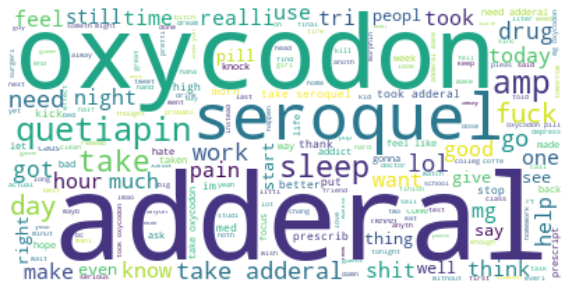

In [7]:
text_wc = " ".join(item for item in clean_text)
wordcloud = WordCloud(background_color="white").generate(text_wc)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show() 

#### custome stop words

In [8]:
new_stopwords = ['seroquel','oxycontin','adderal','oxycodon','quetiapine']
new_stopwords_list = stop_words.union(new_stopwords)

#### transform tf-idf

In [9]:
tfVectorizer=TfidfVectorizer()
tfdtm= tfVectorizer.fit_transform(clean_text)

tfVectorizer.get_feature_names()[0:100]
tfdtm.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
tfidfVec=TfidfVectorizer(min_df=6) 
x = tfidfVec.fit_transform(clean_text)

#### convert to dataframe

In [11]:
df = pd.DataFrame(x.toarray(), columns=tfidfVec.get_feature_names())
df.head()

,abilifi,abl,abus,accident,acetaminophen,act,actual,ad,add,adderal,...,yeah,year,yep,yes,yesterday,yet,yo,yrs,zombi,zopiclon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.366655,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102877,...,0.0,0.280128,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [12]:
df.shape

(3013, 761)

## Machine Learning Model

### Feature Selection

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [14]:
df['abuse'] = abuseTweets.abuse

In [15]:
x=df.drop('abuse',axis=1)
y=df.abuse

#### select top 300 important features

In [16]:
ChiS = SelectKBest(chi2, k=300)
X_new=ChiS.fit_transform(x, y)

In [17]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X_new, y, 
                                                    test_size=0.20, random_state=123) 

### use balanced bagging classifier combined with Multinomial Naive Bayes

In [18]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [19]:
mnb = MultinomialNB()
bbc = BalancedBaggingClassifier(base_estimator=mnb,replacement=True,max_features=112,
                                n_estimators=50)

In [20]:
bbc.fit(x_train, y_train) 

BalancedBaggingClassifier(base_estimator=MultinomialNB(), max_features=112,
                          n_estimators=50, replacement=True)

In [21]:
y_pred = bbc.predict(x_test)
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       509
           1       0.33      0.82      0.47        94

    accuracy                           0.71       603
   macro avg       0.64      0.76      0.64       603
weighted avg       0.86      0.71      0.75       603



### Deep Learning Model RNN

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [25]:
from sklearn.model_selection import train_test_split
y=abuseTweets.abuse
sentences=abuseTweets.text

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.20, random_state=1000)

#### word embedding

In [26]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(sentences_train[2])
print(X_train[2])

SEVEN missed calls? get you're seroquel mg lowered. you're getting ridiculous
[423, 141, 558, 15, 32, 4, 938, 193, 146, 1, 939, 807, 294, 1518]


#### The maximum number of tokens we will allow is set to the average plus 2 standard deviations

In [28]:
num_tokens = [len(tokens) for tokens in X_train + X_test]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

26

In [29]:
maxlen = 26
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[   1   85   20 2227 2228   37    2   12    7 2229 1517    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


#### create the RNN

In [30]:
embedding_dim = 9
RNN1 = Sequential()
RNN1.add(keras.layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
RNN1.add(keras.layers.LSTM(16))
RNN1.add(keras.layers.Dense(1, activation='sigmoid'))
RNN1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 9)             47799     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 49,480
Trainable params: 49,480
Non-trainable params: 0
_________________________________________________________________


In [31]:
embedding_dim = 9
RNN2 = Sequential()
RNN2.add(keras.layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
RNN2.add(keras.layers.Dropout(0.2))
RNN2.add(keras.layers.LSTM(units=16))
RNN2.add(keras.layers.Dropout(0.2))
RNN2.add(keras.layers.Dense(1, activation='sigmoid'))
RNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(RNN2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 9)             47799     
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 9)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 49,480
Trainable params: 49,480
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
embedding_dim = 9
RNN3 = Sequential()
RNN3.add(keras.layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
RNN3.add(keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2))
RNN3.add(keras.layers.Dense(1, activation='sigmoid'))
RNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(RNN3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 26, 9)             47799     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 49,480
Trainable params: 49,480
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
embedding_dim = 9
RNN4 = Sequential()
RNN4.add(keras.layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
RNN4.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
RNN4.add(keras.layers.MaxPooling1D(pool_size=2))
RNN4.add(keras.layers.LSTM(16))
RNN4.add(keras.layers.Dense(1, activation='sigmoid'))
RNN4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(RNN4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 26, 9)             47799     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 32)            1472      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 52,424
Trainable params: 52,424
Non-trainable params: 0
_________________________________________________________________
None


#### get result

In [34]:
class_weight = {1: .9,
                0: .1}

history = RNN4.fit(X_train, y_train,
                    epochs=8,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=5,class_weight=class_weight)
loss, accuracy = RNN4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = RNN4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

/Users/qiqintian/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 0.9959
Testing Accuracy:  0.8391


In [36]:
preds = RNN4.predict_classes(X_test)
print(classification_report(y_test, preds, digits=6))

              precision    recall  f1-score   support

           0   0.895911  0.921606  0.908577       523
           1   0.369231  0.300000  0.331034        80

    accuracy                       0.839138       603
   macro avg   0.632571  0.610803  0.619806       603
weighted avg   0.826036  0.839138  0.831954       603



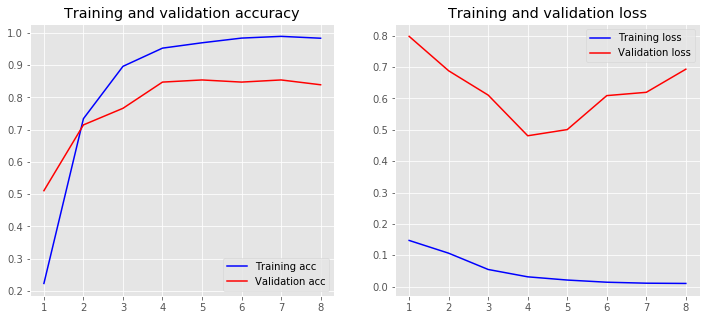

In [37]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)